In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree  import DecisionTreeClassifier
import itertools
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

In [4]:
train=pd.read_csv('Train_data.csv')
test=pd.read_csv('Test_data.csv')
df = pd.concat([train, test], ignore_index=True)
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
#Missing values
total = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

In [6]:
#Duplicate values
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 0


<AxesSubplot:>

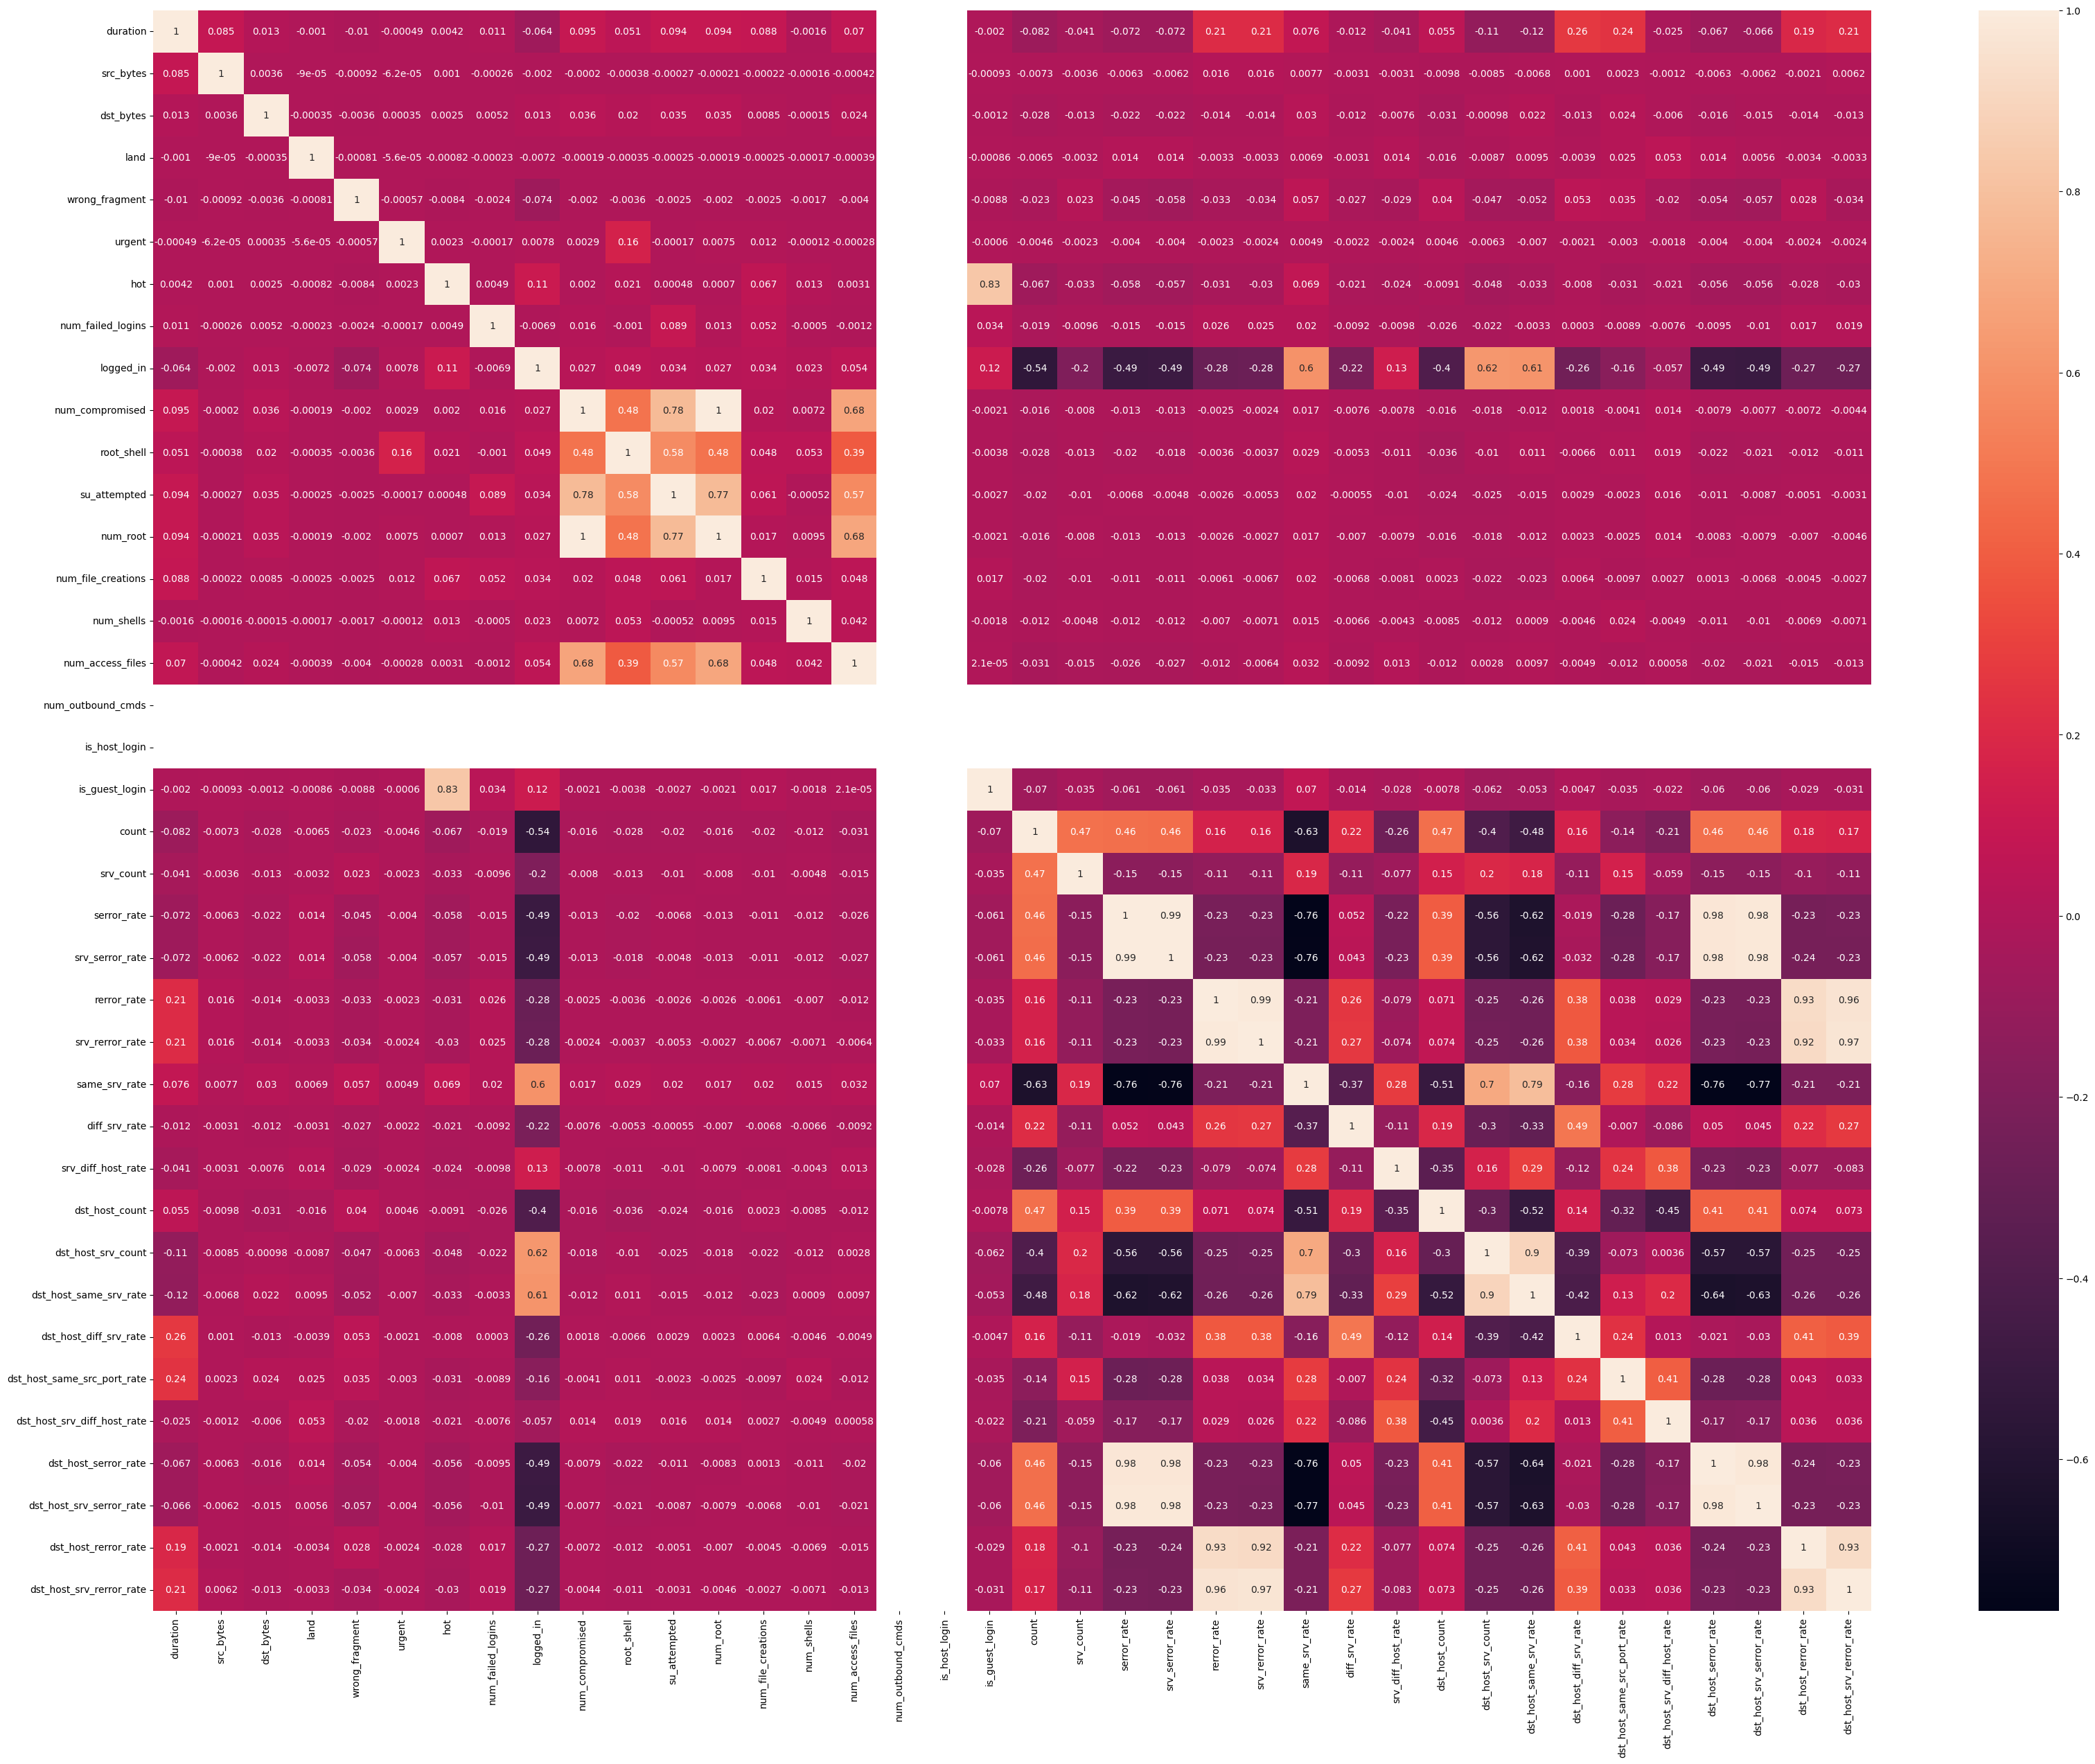

In [7]:
plt.figure(figsize=(40,30))
sns.heatmap(train.corr(), annot=True)

<AxesSubplot:xlabel='class', ylabel='count'>

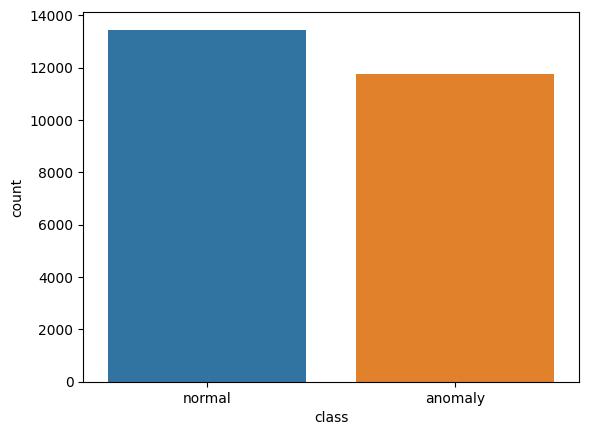

In [8]:
sns.countplot(x=train['class'])

In [9]:
#Label Encoding
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

le(train)
le(test)

In [10]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,19,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,41,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,46,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,22,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,22,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


In [11]:
X_train = train.drop(['class'], axis=1)
Y_train = train['class']

In [12]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate']

In [13]:
X_train = X_train[selected_features]

scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test)

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

In [14]:
def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classifier_obj = DecisionTreeClassifier(max_features = dt_max_features, max_depth = dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [15]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)

[I 2022-10-19 11:10:28,282] A new study created in memory with name: no-name-af92c333-d830-46c0-8c5b-6ca792c27307
[I 2022-10-19 11:10:28,302] Trial 0 finished with value: 0.9693040486901296 and parameters: {'dt_max_depth': 4, 'dt_max_features': 5}. Best is trial 0 with value: 0.9693040486901296.
[I 2022-10-19 11:10:28,344] Trial 1 finished with value: 0.9948399047367028 and parameters: {'dt_max_depth': 22, 'dt_max_features': 10}. Best is trial 1 with value: 0.9948399047367028.
[I 2022-10-19 11:10:28,375] Trial 2 finished with value: 0.9958983858163535 and parameters: {'dt_max_depth': 29, 'dt_max_features': 8}. Best is trial 2 with value: 0.9958983858163535.
[I 2022-10-19 11:10:28,394] Trial 3 finished with value: 0.9931198729822704 and parameters: {'dt_max_depth': 23, 'dt_max_features': 3}. Best is trial 2 with value: 0.9958983858163535.
[I 2022-10-19 11:10:28,426] Trial 4 finished with value: 0.9941783540619211 and parameters: {'dt_max_depth': 19, 'dt_max_features': 7}. Best is trial 

FrozenTrial(number=2, values=[0.9958983858163535], datetime_start=datetime.datetime(2022, 10, 19, 11, 10, 28, 344299), datetime_complete=datetime.datetime(2022, 10, 19, 11, 10, 28, 375976), params={'dt_max_depth': 29, 'dt_max_features': 8}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=2, state=TrialState.COMPLETE, value=None)


In [16]:
dt = DecisionTreeClassifier(max_features = study_dt.best_trial.params['dt_max_features'], max_depth = study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)

print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")

Train Score: 1.0
Test Score: 0.9940460439269648


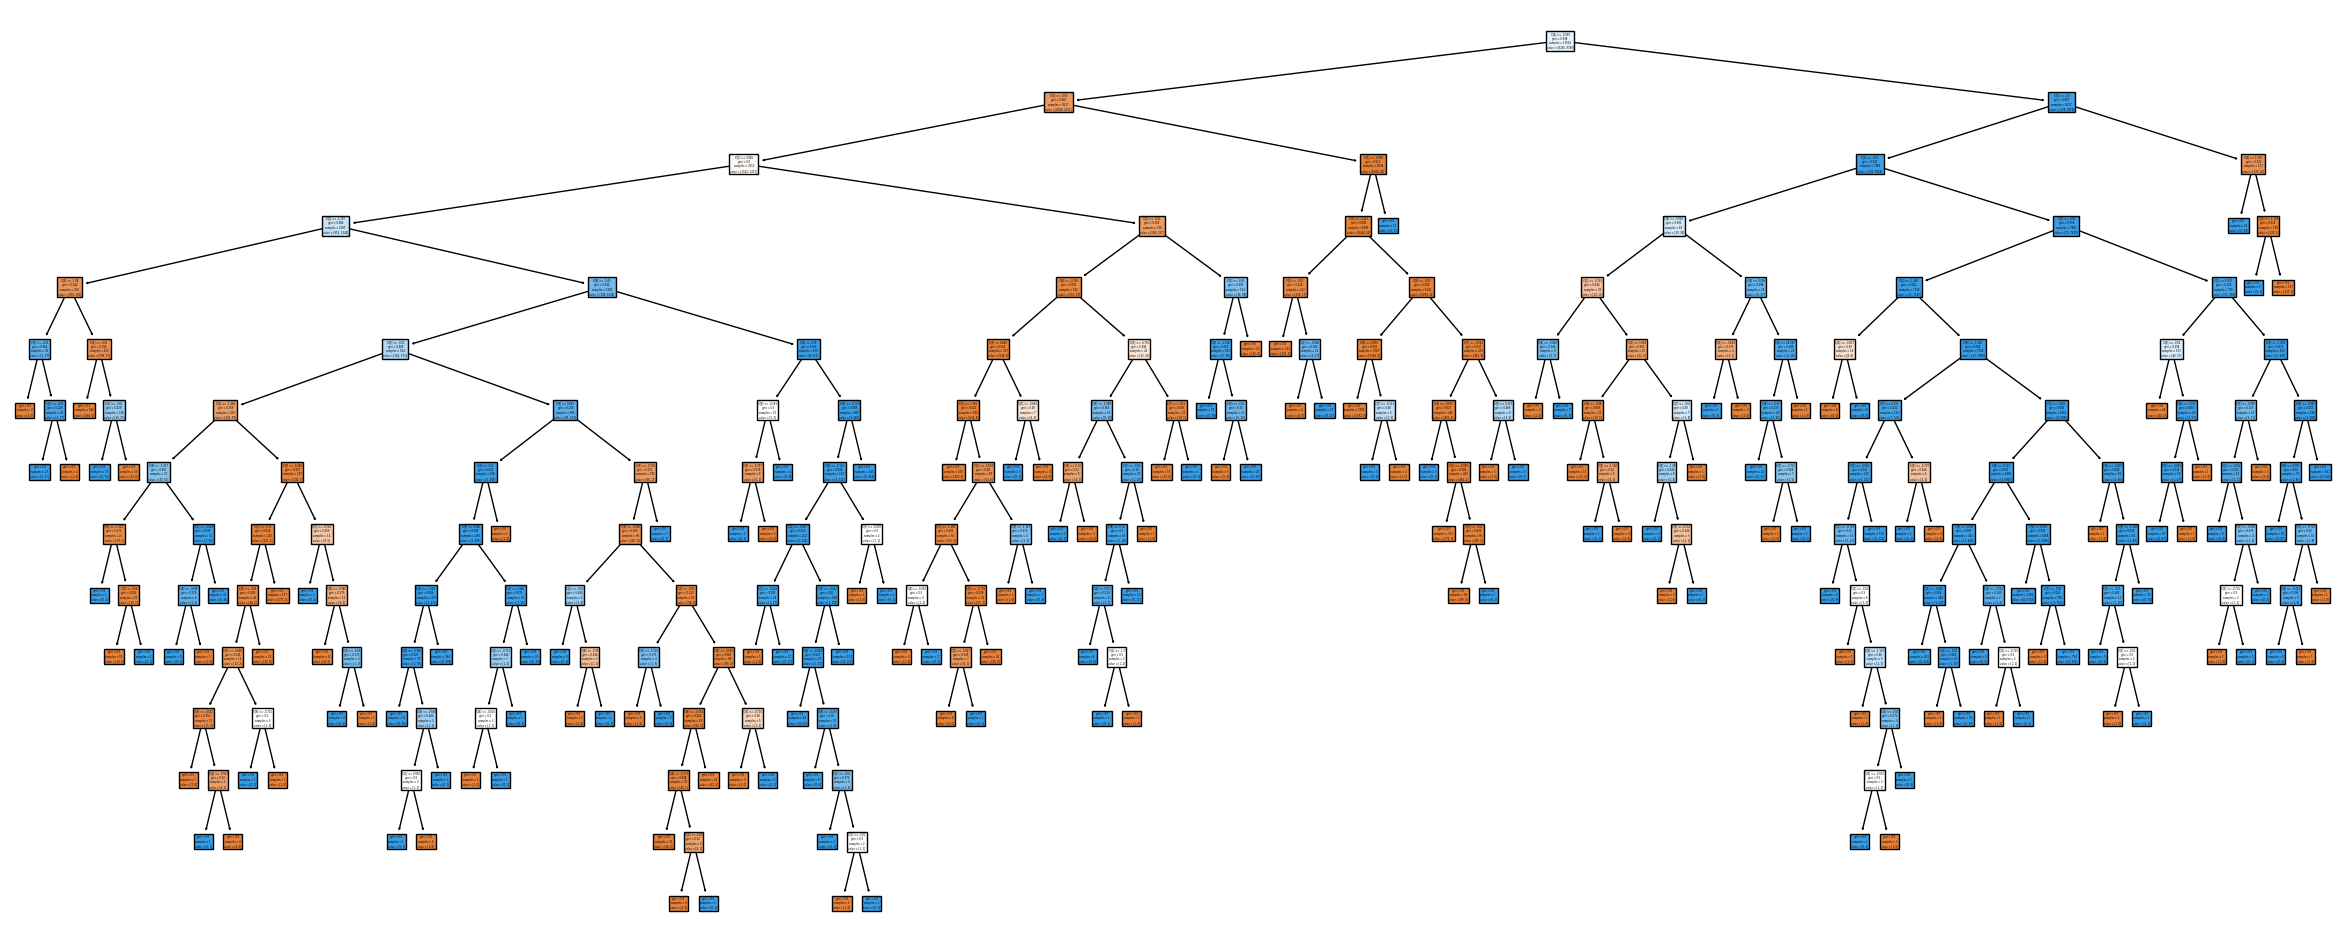

In [17]:
fig = plt.figure(figsize = (30,12))
tree.plot_tree(dt, filled=True);
plt.show()